In [99]:
__author__: "Matt Canrey"
__date__ : "20220816"
__stage__: "Dev"
__Version__: "0.0.1"

## Import Libraries

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold

## Directory

In [101]:
# Configure root, src, and data filepaths
fp_root = os.getcwd().replace('src', '')
fp_src = os.path.join(fp_root, 'src')
fp_data = os.path.join(fp_root, 'data')

## Import Data

In [102]:
# Import adult income data
income_csv = os.path.join(fp_data, 'adult.csv')
df_income = pd.read_csv(income_csv)

## Cleaning and EDA

In [103]:
df_income.shape
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [104]:
# Check for NAs - No NAs
#for i in df_income.columns:
#    print(i, df_income[i].isna().sum())

<AxesSubplot:>

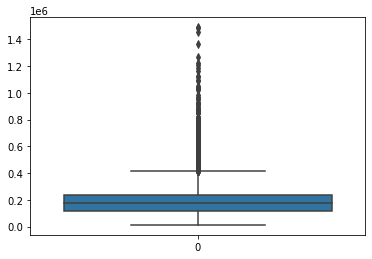

In [105]:
sns.boxplot(data=df_income['fnlwgt'])

In [106]:
# Remove outliers
num_cols = df_income.select_dtypes(int).columns
for col in num_cols:
    nine_five =  df_income[col].quantile(0.95)
    five = df_income[col].quantile(0.05)
    df_income = df_income[(df_income[col] <= nine_five) | (df_income[col] <= five)]


## Pre-processing

In [108]:
# Categorical Encoding
df_income = pd.get_dummies(df_income.select_dtypes(include='object'), drop_first=1) # gender_Male new target variable

# Target and features
y = df_income['gender_Male']
X = df_income.drop(columns= 'gender_Male')

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=123, stratify=y)


## Baseline Modeling

In [124]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [110]:
def baseline_models(X_train, y_train, cv=5):
        """
        Inputs: Feature training data, target training data
        Outputs: Dataframe of baseline model performance from models
        """
        # Metrics
        metrics = ['accuracy', 'roc_auc']

        # Transformers
        #scaler = StandardScaler()

        # Models
        dt = DecisionTreeClassifier(random_state=123)
        rf = RandomForestClassifier(random_state=123)
        gb = GradientBoostingClassifier(random_state=123)
        baseline_models =  [('Decision Tree Classifier', dt),
                        ('Random Forest Classifier', rf),
                        ('Gradient Boosting Classifier', gb)]

        # Create dataframe to aggregate performance
        cols = ['Model', 'Fit Time', 'Train accuracy', 'Test accuracy', 'Train ROC AUC', 'Test ROC AUC']
        df_baseline = pd.DataFrame(columns=cols)

        for model_name, model in baseline_models:
                pipeline = Pipeline(steps=[
                                #('transfomer', scaler),
                                ('models', model)])

                cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring = metrics, return_train_score=True)
                
                vals = [model_name, cv_results['fit_time'].mean(),
                        cv_results['train_accuracy'].mean(), 
                        cv_results['test_accuracy'].mean(),
                        cv_results['train_roc_auc'].mean(),
                        cv_results['test_roc_auc'].mean()]
                
                df_baseline.loc[len(df_baseline)] = vals
        
                #pipelines.append(pipeline)
        #print(f"{model_name} complete")
        return df_baseline

In [111]:
# Run Model
df_baseline = baseline_models(X_train, y_train)

In [112]:
df_baseline

,Model,Fit Time,Train accuracy,Test accuracy,Train ROC AUC,Test ROC AUC
0,Decision Tree Classifier,0.126051,0.885809,0.813838,0.965821,0.865501
1,Random Forest Classifier,2.154116,0.885800,0.820783,0.963543,0.910128
2,Gradient Boosting Classifier,2.890463,0.830669,0.828393,0.924179,0.921444


## Model Assessment

In [113]:
# FIt selected model 
gb = GradientBoostingClassifier(random_state=123)
gb.fit(X_train, y_train)


GradientBoostingClassifier(random_state=123)

In [119]:
y_pred = gb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.8184235012627941

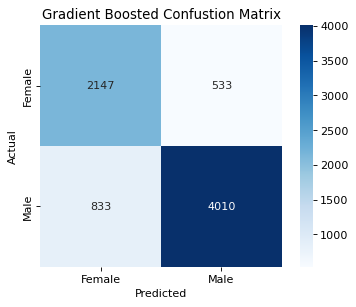

In [123]:
# Confusion matrix heat map
# Confusion Matrix
cv_confusion = confusion_matrix(y_test, y_pred)

plt.figure(dpi=80)
sns.heatmap(cv_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt="d",
           xticklabels=['Female', 'Male'],
           yticklabels=['Female', 'Male'])
plt.gcf().set_facecolor('white')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boosted Confustion Matrix');

In [125]:
#Generate data frame of model test statistics
y_probs = gb.predict_proba(X_test)[:,1]
thresholds = []
f1 = []
precisions = []
recall = []
tn = []
fp = []
fn = []
tp = []

for t in range(0,105,10):
    y_pred = pd.Series(y_probs).apply(lambda x: 0 if x<t/100 else 1)
    thresholds.append(t/100)
    f1.append(f1_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    tn.append(confusion_matrix(y_test, y_pred)[0][0])
    fp.append(confusion_matrix(y_test, y_pred)[0][1])
    fn.append(confusion_matrix(y_test, y_pred)[1][0])
    tp.append(confusion_matrix(y_test, y_pred)[1][1])
    

test_statistics = pd.DataFrame(
    {'Threshold': thresholds,
     'F1 Score' : f1,
     'Precision': precisions,
     'Recall' : recall,
     'True_Negative': tn,
     'False_Positive': fp,
     'False_Negative': fn,
     'True_Positive': tp,
    })

test_statistics

c:\Users\mcarney\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Threshold,F1 Score,Precision,Recall,True_Negative,False_Positive,False_Negative,True_Positive
0,0.0,0.783277,0.643759,1.000000,0,2680,0,4843
1,0.1,0.820391,0.696983,0.996903,581,2099,15,4828
2,0.2,0.841587,0.733068,0.987817,938,1742,59,4784
3,0.3,0.858072,0.779841,0.953748,1376,1304,224,4619
4,0.4,0.862252,0.795705,0.940946,1510,1170,286,4557
5,0.5,0.854464,0.882677,0.827999,2147,533,833,4010
6,0.6,0.841406,0.944473,0.758621,2464,216,1169,3674
7,0.7,0.826087,0.965479,0.721867,2555,125,1347,3496
8,0.8,0.814583,0.976067,0.698947,2597,83,1458,3385
9,0.9,0.725266,0.997110,0.569895,2672,8,2083,2760


Text(0.5, 0, 'Threshold')

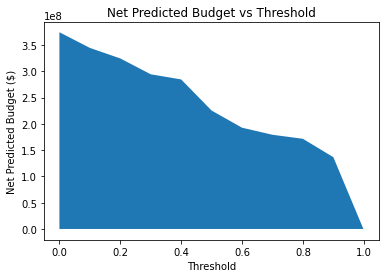

In [127]:
plt.stackplot(areaplot['Threshold'], areaplot['Over Budget'])
plt.title('Net Predicted Budget vs Threshold')
plt.ylabel('Net Predicted Budget ($)')
plt.xlabel('Threshold')

In [128]:
areaplot = test_statistics[['Threshold', 'False_Positive', 'False_Negative', 'True_Positive']]
areaplot['Predicted Cost'] = (test_statistics['False_Positive'] + test_statistics['True_Positive']) *50000
areaplot['Actual Cost'] = (test_statistics['False_Negative'] + test_statistics['True_Positive']) * 50000
#areaplot['Actual Cost'] = (180000 - areaplot['Predicted Cost'])
areaplot['Over Budget'] = areaplot['Predicted Cost'] - 1800000
#areapl = areaplot[['Threshold', 'Predicted Cost', 'Actual Cost']]

C:\Users\mcarney\AppData\Local\Temp/ipykernel_18988/200036397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  areaplot['Predicted Cost'] = (test_statistics['False_Positive'] + test_statistics['True_Positive']) *50000
C:\Users\mcarney\AppData\Local\Temp/ipykernel_18988/200036397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  areaplot['Actual Cost'] = (test_statistics['False_Negative'] + test_statistics['True_Positive']) * 50000
